In [1]:
#imports

# prepare tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import re
import string

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
#Loading the dataset

def load_doc(filename):
    #open the file
    file = open(filename, 'rt',encoding='utf-8')
    #read the text
    text = file.read()
    #close the file
    file.close()
    return text

path = "shona_2.txt"
text = load_doc(path)
print(text[:200])

Zein paaive nemakore mana Amainini Tsitsi vakamuendesa kuchikoro. Sevamwe vana akatanga kudzidza kunyangwe aiva mudiki pazera zera rake kuti atange kuita Grade . Musi wake wekutanga kupinda chikoro ak


## Preprocessing

In [3]:
def preprocess(text):
    # replace ' -- ' with a space ' '
    text = text.replace( '--' , ' ' )


    #Tokenization(Split by whitespace)
    words = text.split()

    #removing utf-8 encoding characters and other unnecessary chars
    words = [re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff\xad\x0c6§\[\]\\\£\Â\n\r]', ' ', word) for word in words]
    words = [word for word in words if word.isalpha()]

    #removing all numerical values(page numbers)
    words = [re.sub(r'[0123456789]', ' ', word) for word in words]

    #removing all punctuation
    re_punc = re.compile( ' [%s] ' % re.escape(string.punctuation))
    words = [re_punc.sub( '' , word) for word in words]

    #removing Roman numerals
    # first capitalized ones
    words = [re.sub(r'\s((I{2,}V*X*\.*)|(IV\.*)|(IX\.*)|(V\.*)|(V+I*\.*)|(X+L*V*I*]\.*))\s', ' ', word) for word in words]
    # then lowercase
    words = [re.sub(r'\s((i{2,}v*x*\.*)|(iv\.*)|(ix\.*)|(v\.*)|(v+i*\.*)|(x+l*v*i*\.*))\s', ' ', word) for word in words]


    #removing all strings of capital letters that are more than 2 characters long(Headings)
    words = [re.sub(r'[A-Z]{2,}', ' ', word) for word in words]


    #removing extra white spaces
    words = [re.sub(r'\s+', ' ', word) for word in words]


    #converting all words to lower case
    clean_words = [word.lower() for word in words]



    #removing empty strings
    for word in clean_words:
        if((len(word)) == 1):
            clean_words.remove(word)

    return clean_words

In [4]:
text_corpus = preprocess(text)
text_corpus[200:220]

['pamwe',
 'nevana',
 'vaviri',
 'netsaona',
 'pavakati',
 'pfacha',
 'muguta',
 'reharare',
 'maziso',
 'azein',
 'aimhanya',
 'pose',
 'marobhoti',
 'achiti',
 'sezvo',
 'vakasvika',
 'pavakaburuka',
 'bhazi',
 'kwaifefetera',
 'kamhepo']

In [5]:
#Building a Vocabulary of unique words
#new_text = load_doc("/content/gdrive/My Drive/NLP/shona.txt")
#new_text_corpus = preprocess(new_text)
vocab = set(text_corpus)

#get the vocabulary size
len(vocab)


15000

In [6]:
#Tokenizing the text using Keras

t = Tokenizer(oov_token = "<OOV>",num_words=len(text_corpus))
t.fit_on_texts(text_corpus)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(text_corpus)

# pad documents to a max length of 100 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding= 'post')
#print(padded_docs[:2])
word_index = t.word_index

In [7]:
len(text_corpus)

48012

## Word Embeddings

In [8]:
import nltk
nltk.download('punkt')
# Split text into sentences
sentences = nltk.sent_tokenize(text.lower())

# Split each sentence into words and create separate lists for each sentence
sentence_words = [nltk.word_tokenize(sentence) for sentence in sentences]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [9]:
sentence_words[300]

['hana',
 'yazein',
 'yaikwata',
 'nekurova',
 'achienda',
 'pakagara',
 'mainini',
 'tsitsi',
 '.']

In [10]:
#using the gensim library
import gensim
from gensim.models import Word2Vec

model = Word2Vec(sentence_words,min_count=3, sg=8)

Visualizing the word embeddings

In [11]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

#reducing the high-dimensional word vectors to two-dimensional plots
keys = list(model.wv.key_to_index.keys())
X = model.wv[keys]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

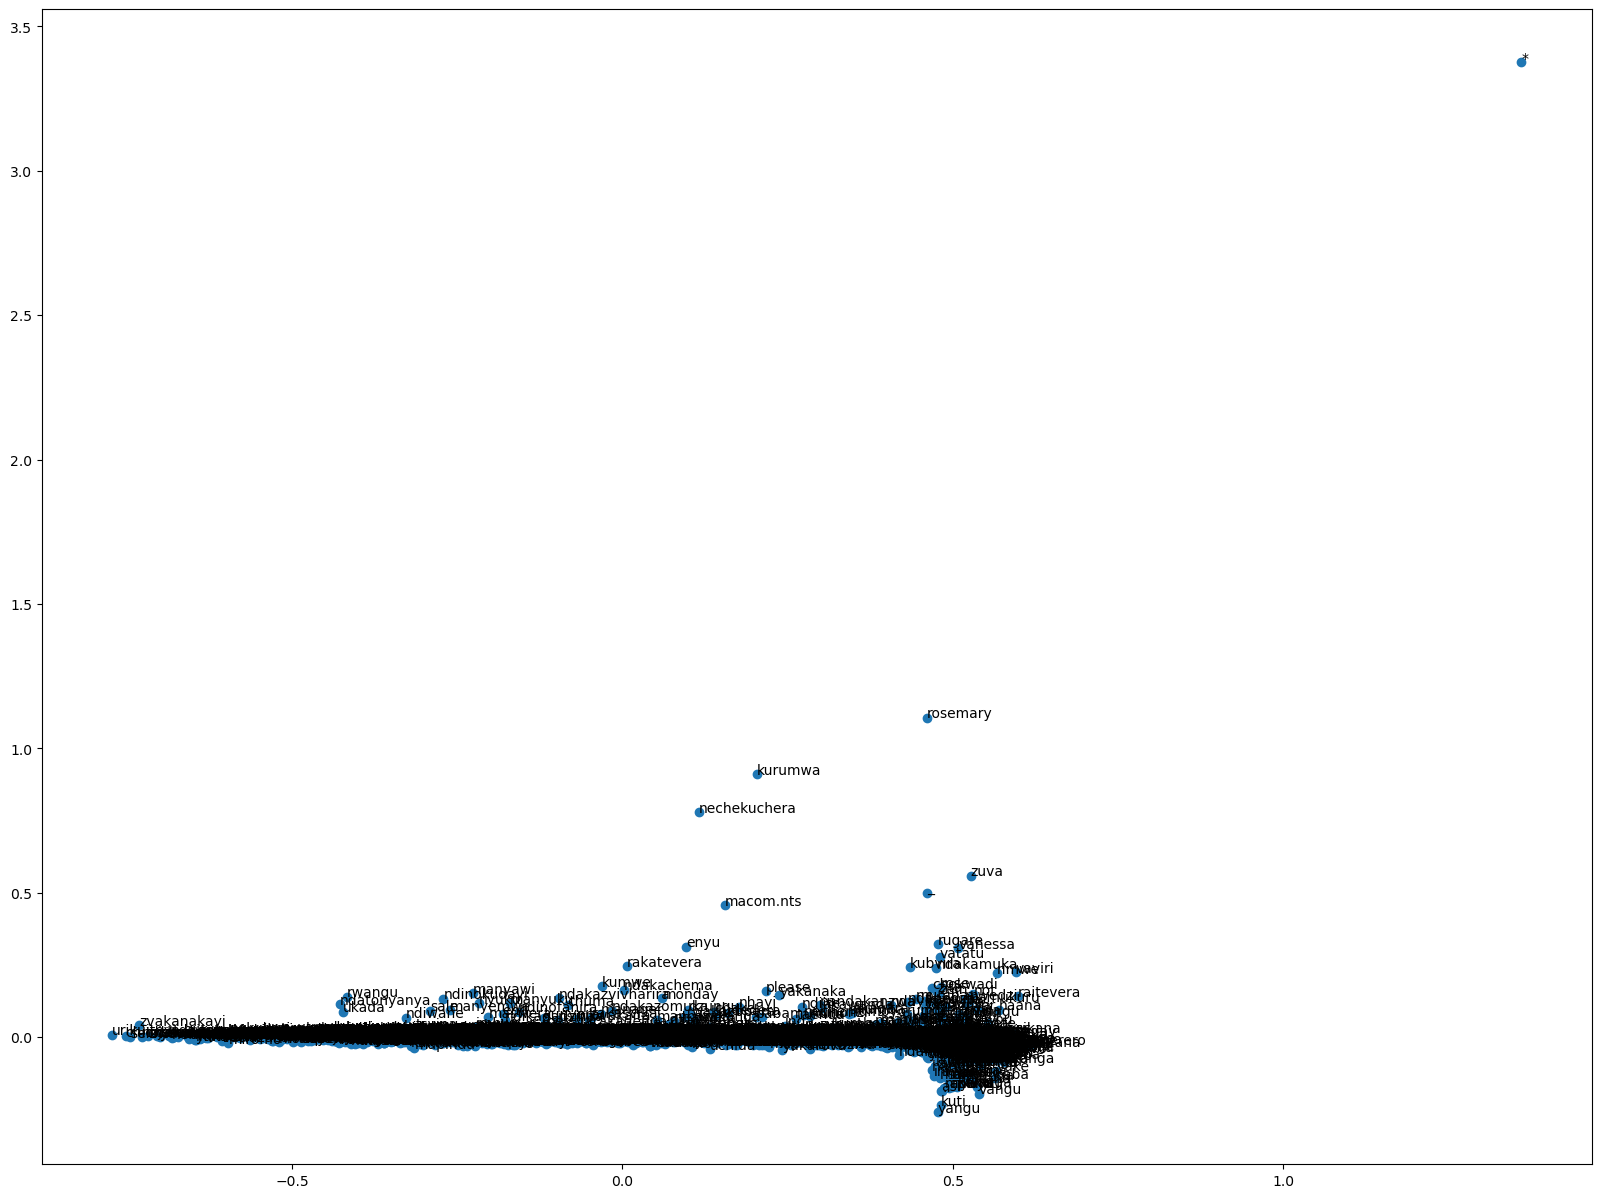

In [12]:
# create a scatter plot of the projection
pyplot.figure(figsize=(20, 15))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index.keys())
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [59]:
#creating an embedding matrix
# Get the word vectors from the trained model
word_vectors = model.wv

# Create the embedding matrix
embedding_dim = model.vector_size
#vocabu_size = len(word_vectors.key_to_index)
vocabu_size = len(vocab) - 6
embedding_matrix = np.zeros((vocabu_size, embedding_dim))

for word, index in word_vectors.key_to_index.items():
    embedding_vector = word_vectors[word]
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Creating Input Sequences

In [14]:
#function to save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n' .join(lines)
    file = open(filename, 'w' )
    file.write(data)
    file.close()

In [15]:
#the sequences will be 6 words long(with the first 5 being used for training and the 6th being the target)
#making lines of text
length = 5 + 1
sequences = list()
for i in range(length, len(text_corpus)):
# select sequence of tokens
    seq = text_corpus[i-length:i]
# convert into a line
    line = ' ' .join(seq)
# store
    sequences.append(line)
print( ' Total Sequences: %d ' % len(sequences))
# save sequences to file
out_filename = 'organized_sequences.txt'
save_doc(sequences, out_filename)


 Total Sequences: 48006 


Encoding the sequences

In [16]:
def load(filename):
    #open the file
    file = open(filename, 'rt')
    #read the text
    text = file.read()
    #close the file
    file.close()
    return text

In [17]:
# load
in_filename = 'organized_sequences.txt'
doc = load(in_filename)
lines = doc.split( '\n' )

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
padded_sequences = pad_sequences(sequences)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 2

**Separating Sequences into Input and Output(X and Y)**

In [18]:
from keras.utils import to_categorical

# separate into input and output
sequences = np.asarray(padded_sequences)
X, y = sequences[:,:-1], sequences[:,-1]
#one hot encoding the output word
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

In [19]:
X[:5]

array([[  34, 2625, 1904,  884, 1030],
       [2625, 1904,  884, 1030,   56],
       [1904,  884, 1030,   56, 2627],
       [ 884, 1030,   56, 2627, 4415],
       [1030,   56, 2627, 4415,   38]])

In [20]:
seq_length

5

In [21]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Building a Bi-directional RNN

In [22]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.initializers import Constant


In [23]:
#Defining the first model
def define_model1(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size,100,input_length=seq_length))
    model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.1)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(vocab_size, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the model summary
    model.summary()

    return model

First model

In [25]:
model_1 = define_model1(vocab_size= 14994 ,seq_length=seq_length)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 100)            1499400   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 14994)             974610    
                                                                 
Total params: 2566746 (9.79 MB)
Trainable params: 2566746 (9.79 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Second Model

In [60]:
model_2 = Sequential()
model_2.add(Embedding(vocabu_size,embedding_dim, 
                        embeddings_initializer=Constant(embedding_matrix)
                        ,input_length=seq_length,trainable=False))
model_2.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.1)))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(vocab_size, activation='softmax'))
model_2.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
model_2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 5, 100)            1499400   
                                                                 
 bidirectional_12 (Bidirect  (None, 128)               84480     
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 14994)             974610    
                                                                 
Total params: 2566746 (9.79 MB)
Trainable params: 1067346 (4.07 MB)
Non-trainable params: 1499400 (5.72 MB)
___________

Model Training

In [27]:
#First Training
num_epochs = 100

history1 = model_1.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=num_epochs,batch_size=120)

Epoch 1/100
361/361 [==============================] - 33s 69ms/step - loss: 8.7110 - accuracy: 0.0349 - val_loss: 8.5629 - val_accuracy: 0.0383
Epoch 2/100
361/361 [==============================] - 23s 64ms/step - loss: 8.2632 - accuracy: 0.0354 - val_loss: 8.7033 - val_accuracy: 0.0383
Epoch 3/100
361/361 [==============================] - 23s 64ms/step - loss: 8.1039 - accuracy: 0.0354 - val_loss: 8.8800 - val_accuracy: 0.0383
Epoch 4/100
361/361 [==============================] - 23s 64ms/step - loss: 7.9549 - accuracy: 0.0354 - val_loss: 9.0471 - val_accuracy: 0.0379
Epoch 5/100
361/361 [==============================] - 23s 64ms/step - loss: 7.7924 - accuracy: 0.0354 - val_loss: 9.3715 - val_accuracy: 0.0348
Epoch 6/100
361/361 [==============================] - 23s 64ms/step - loss: 7.6390 - accuracy: 0.0357 - val_loss: 9.6719 - val_accuracy: 0.0333
Epoch 7/100
361/361 [==============================] - 23s 65ms/step - loss: 7.5031 - accuracy: 0.0360 - val_loss: 10.1463 - val_a

Epoch 57/100
361/361 [==============================] - 23s 63ms/step - loss: 2.3771 - accuracy: 0.4682 - val_loss: 30.6602 - val_accuracy: 0.0192
Epoch 58/100
361/361 [==============================] - 23s 62ms/step - loss: 2.3444 - accuracy: 0.4754 - val_loss: 30.4014 - val_accuracy: 0.0190
Epoch 59/100
361/361 [==============================] - 23s 63ms/step - loss: 2.3122 - accuracy: 0.4806 - val_loss: 30.8640 - val_accuracy: 0.0219
Epoch 60/100
361/361 [==============================] - 23s 63ms/step - loss: 2.2751 - accuracy: 0.4846 - val_loss: 30.8875 - val_accuracy: 0.0200
Epoch 61/100
361/361 [==============================] - 23s 64ms/step - loss: 2.2627 - accuracy: 0.4889 - val_loss: 30.8620 - val_accuracy: 0.0212
Epoch 62/100
361/361 [==============================] - 23s 64ms/step - loss: 2.2306 - accuracy: 0.4905 - val_loss: 31.0093 - val_accuracy: 0.0229
Epoch 63/100
361/361 [==============================] - 23s 64ms/step - loss: 2.1915 - accuracy: 0.5002 - val_loss: 31

In [61]:
#Second Training
num_epochs = 100

history2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=num_epochs,batch_size=120)

Epoch 1/100
361/361 [==============================] - 26s 52ms/step - loss: 8.6927 - accuracy: 0.0350 - val_loss: 8.5748 - val_accuracy: 0.0383
Epoch 2/100
361/361 [==============================] - 17s 48ms/step - loss: 8.3546 - accuracy: 0.0354 - val_loss: 8.6992 - val_accuracy: 0.0383
Epoch 3/100
361/361 [==============================] - 17s 48ms/step - loss: 8.3134 - accuracy: 0.0354 - val_loss: 8.7973 - val_accuracy: 0.0383
Epoch 4/100
361/361 [==============================] - 18s 49ms/step - loss: 8.2984 - accuracy: 0.0354 - val_loss: 8.8818 - val_accuracy: 0.0383
Epoch 5/100
361/361 [==============================] - 17s 48ms/step - loss: 8.2845 - accuracy: 0.0354 - val_loss: 8.9686 - val_accuracy: 0.0383
Epoch 6/100
361/361 [==============================] - 17s 48ms/step - loss: 8.2731 - accuracy: 0.0354 - val_loss: 9.0609 - val_accuracy: 0.0383
Epoch 7/100
361/361 [==============================] - 17s 48ms/step - loss: 8.2578 - accuracy: 0.0354 - val_loss: 9.0952 - val_ac

Epoch 57/100
361/361 [==============================] - 17s 48ms/step - loss: 6.3349 - accuracy: 0.0381 - val_loss: 15.6568 - val_accuracy: 0.0362
Epoch 58/100
361/361 [==============================] - 17s 48ms/step - loss: 6.3213 - accuracy: 0.0386 - val_loss: 15.7815 - val_accuracy: 0.0365
Epoch 59/100
361/361 [==============================] - 17s 48ms/step - loss: 6.3102 - accuracy: 0.0392 - val_loss: 15.8896 - val_accuracy: 0.0358
Epoch 60/100
361/361 [==============================] - 17s 48ms/step - loss: 6.2956 - accuracy: 0.0386 - val_loss: 15.9109 - val_accuracy: 0.0360
Epoch 61/100
361/361 [==============================] - 17s 48ms/step - loss: 6.2790 - accuracy: 0.0383 - val_loss: 16.1679 - val_accuracy: 0.0365
Epoch 62/100
361/361 [==============================] - 18s 49ms/step - loss: 6.2671 - accuracy: 0.0400 - val_loss: 16.0247 - val_accuracy: 0.0358
Epoch 63/100
361/361 [==============================] - 17s 48ms/step - loss: 6.2506 - accuracy: 0.0401 - val_loss: 16

# Model Evaluation

In [64]:
#evaluation function
def evaluate(history):
  pyplot.subplot(2,1,1)
  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy'])
  pyplot.title('model accuracy')
  pyplot.ylabel('accuracy')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'val'], loc='lower right')

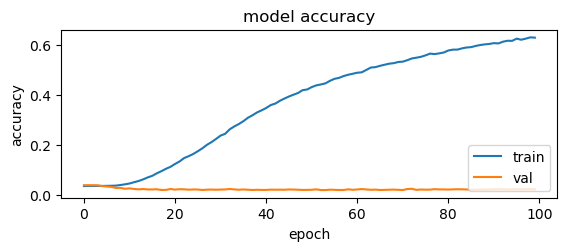

In [65]:
#evalutaing the first model
evaluate(history1)

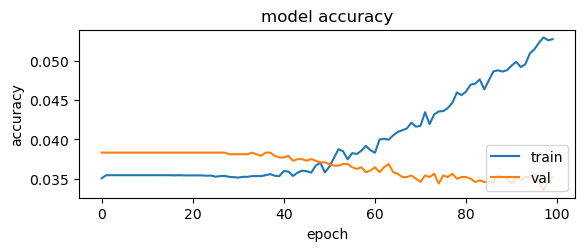

In [67]:
#evalutaing the second model
evaluate(history2)

In [68]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
        result = list()
        in_text = seed_text
        # generate a fixed number of words
        for _ in range(n_words):
                # encode the text as integer
                encoded = tokenizer.texts_to_sequences([in_text])[0]
                # truncate sequences to a fixed length
                encoded = pad_sequences([encoded], maxlen=seq_length, truncating= 'pre' )
                # predict probabilities for each word
                #yhat = np.round(model.predict(encoded, verbose=0)).astype(int)
                yhat = np.argmax(model.predict(encoded, verbose=0),axis=1)
                # map predicted word index to word
                out_word = ''
                for word, index in tokenizer.word_index.items():
                        if index == yhat:
                                out_word = word
                                break
                # append to input
                in_text += ' ' + out_word
                result.append(in_text)
        return ' ' .join(result)

In [69]:
seed_text = "baba vangu vanomukira kuenda kubasa"
print(seed_text + ' \n ' )

baba vangu vanomukira kuenda kubasa 
 


In [70]:
result = generate_seq(model=model_2,tokenizer=tokenizer,seq_length=seq_length,seed_text=seed_text,n_words=1)
result

'baba vangu vanomukira kuenda kubasa kuti'

# Saving the best model

In [72]:
from pickle import dump
# save the model to file
model_2.save( 'model.h5' )
# save the tokenizer
dump(tokenizer, open( 'tokenizer.pkl' , 'wb' ))